In [1]:
# !pip install git+https://github.com/jbusecke/cmip6_preprocessing.git@refs/pull/187/head
# !mamba install regionmask -y

## Outline

- Access to CMIP6 data
    - How do i get to the data?
    - How do I select certain variables/experiments/models?
        - Handy CSV from Naomi
- Why would I need a preprocessing package?
    - Examples of messed up conventions
    - combined preprocessing
    
- Combining datasets for analysis
    - Matching metrics
    - Combining datasets

- Masking out ocean basins

- Removing trends from the data

In this tutorial you will learn how to work with CMIP6 data in the cloud.
This includes:
- Finding and selecting data
- Loading the data
- Combining different datasets
- Masking out ocean basins
- Removing model drift
    
All of these assume a basic knowledge of python and xarray.

## What is CMIP6?


...

## Where do I find the data?

The official CMIP6 archive is maintained by [ESGF](https://esgf-node.llnl.gov/projects/cmip6/), but downloadind data from there can be a time and storage consuming task. The pangeo Project has mirrored a substantial part of the archive to the [cloud](https://pangeo-data.github.io/pangeo-cmip6-cloud/) (not all of them though, so if you are missing something always check on the ESGF site first).

So now that you know where the data is located (we are going to use the data on Google Cloud, since this is where our computations will happen). 

All the CMIP6 variables follow a stric vocabulary, so you might want to check out this handy [spreadsheet by Naomi Henderson](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271)

Ok then lets get started...

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import intake
from dask.diagnostics import ProgressBar

In [3]:
from cmip6_preprocessing.utils import google_cmip_col

# Initialize the Pangeo CMIP6 cloud collection
col = google_cmip_col()

The collection is based on a pandas dataframe:


In [4]:
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfss,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,6hrPlev,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,clt,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
511171,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,clt,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511172,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511173,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,day,hfls,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511174,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...,NaN,20210721


The column names represent another set of 'vocabulary' that is useful to learn. Especially the values of `source_id` (the model), `experiment_id` the experiment that was run, and `table_id`(time frequency of output) will apear again and again.
We could just find the dataset we want to analyze and [manually load it with xarray](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#opening-a-single-zarr-data-store), but that is cumbersome.

Instead we are using the abilities of the `col` object, powered by [intake-esm](https://intake-esm.readthedocs.io/en/latest/) to narrow down our search critera and load the data.

In [32]:
np.sort(col.df['source_id'].unique())

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-HR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM1-1-CAM5-CMIP5', 'CESM1-WACCM-SC', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-CM2-VHR4', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-LR',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P', 'EC-Earth3P-HR',
       'EC-Earth3P-VHR', 'ECMWF-IFS-HR', 'ECMWF-IFS-LR', 'FGOALS-f3-H',
       'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-ESM4', 'GFDL-OM4p5B',
       'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-LM',
       'HadGEM3-GC31-MM', 'IITM-ESM', 'I

In [38]:
# create a subcollection with certain search criteria

models = ['CanESM5-CanOE', 'IPSL-CM6A-LR']
cat = col.search(
    variable_id=['tos', 'zos'],
    source_id=models,
    experiment_id=['historical', 'ssp585'],
    grid_label='gn',
    table_id='Omon',
    member_id = ['r2i1p1f1', 'r3i1p1f1', 'r2i1p2f1', 'r3i1p2f1'] # load only two members for demo purposes
)

# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [39]:
list(ddict.keys())

['CMIP.IPSL.IPSL-CM6A-LR.historical.r3i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r3i1p1f1/Omon/tos/gn/v20180803/.nan.20180803',
 'CMIP.CCCma.CanESM5-CanOE.historical.r3i1p2f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r3i1p2f1/Omon/tos/gn/v20190429/.nan.20190429',
 'CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1.Omon.zos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r2i1p2f1/Omon/zos/gn/v20190429/.nan.20190429',
 'ScenarioMIP.CCCma.CanESM5-CanOE.ssp585.r2i1p2f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5-CanOE/ssp585/r2i1p2f1/Omon/tos/gn/v20190429/.nan.20190429',
 'ScenarioMIP.CCCma.CanESM5-CanOE.ssp585.r2i1p2f1.Omon.zos.gn.gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5-CanOE/ssp585/r2i1p2f1/Omon/zos/gn/v20190429/.nan.20190429',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.r3i1p1f1.Omon.zos.gn.gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r3i1p1f1/Omon/zos/gn/v20191121/.nan.20191121',
 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp5

The result is a python dictionary with many xarray Datasets

In [41]:
ds_a = ddict['CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1.Omon.zos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r2i1p2f1/Omon/zos/gn/v20190429/.nan.20190429']
ds_a

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, time: 1980, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    zos                 (time, j, i) float32 dask.array<chunksize=(208, 291, 360), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his02
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variant_label:               r2i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/02be791e-da03-4013-820c-2ad279c...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1...

In [42]:
ds_b = ddict['CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Omon.zos.gn.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r2i1p1f1/Omon/zos/gn/v20180803/.nan.20180803']
ds_b

<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, time: 1980, x: 362, y: 332)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    zos             (time, y, x) float32 dask.array<chunksize=(242, 332, 362), meta=np.ndarray>
Attributes: (12/56)
    CMIP6_CV_version:        cv=6.2.3.5-2-g63b123e
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   historical
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    ...                      ...
    variant_label:           r2i1p1f1
    status:                  2019-11-10;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/969c9240-316b-4b75-823a-715029a70124
    version_id:              v20180803
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Omon....

Ok cool, that looks great, doesnt it? Why would I need cmip6_preprocessing? Well take a closer look at for instance the dimensions:

In [43]:
print(ds_a.dims)
print(ds_b.dims)

Frozen(SortedKeysDict({'i': 360, 'j': 291, 'time': 1980, 'bnds': 2, 'vertices': 4}))
Frozen(SortedKeysDict({'y': 332, 'x': 362, 'nvertex': 4, 'time': 1980, 'axis_nbounds': 2}))


Oh damn, these are not the same and so if you want to average several model in space, you would have to write a ton of `if/else` statements...
This is the original reason I wrote cmip6_preprocessing: To take thes tedious bookkeeping tasks out and enable users to work with truly analysis ready data

In [44]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
print(combined_preprocessing(ds_a).dims)
print(combined_preprocessing(ds_b).dims)

Frozen(SortedKeysDict({'x': 360, 'y': 291, 'time': 1980, 'bnds': 2, 'vertex': 4}))
Frozen(SortedKeysDict({'y': 332, 'x': 362, 'vertex': 4, 'time': 1980, 'bnds': 2}))


🚀 Now things look great. But for convenience you can also plug this functionality in your 'read-in' procedure:


In [65]:
# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # this applies the preprocessing to all datasets
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


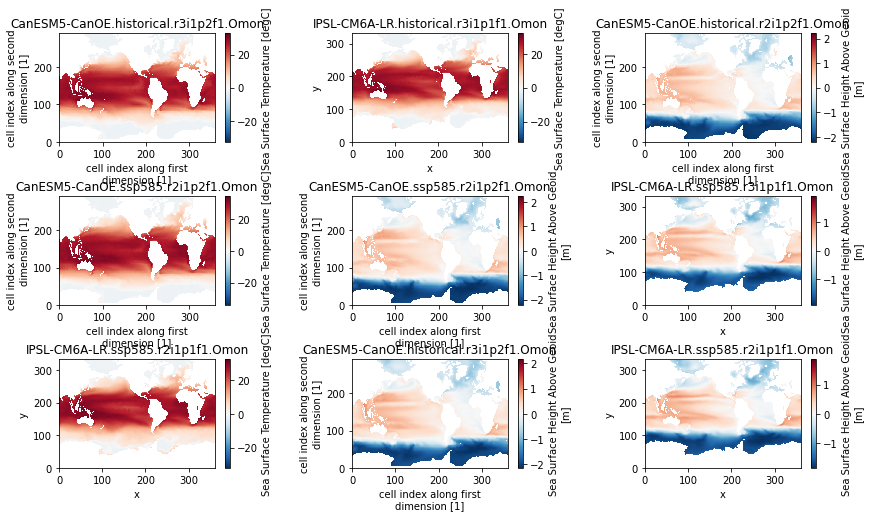

In [46]:
# quick example of how to loop over several models
from cmip6_preprocessing.utils import cmip6_dataset_id
fig, axarr = plt.subplots(ncols=3, nrows=3, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # select the first time step
    ds = ds.isel(time=0)
    # select the datavariable
    da = ds[ds.variable_id]
    # plot
    
    da.plot(ax=ax)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
    
fig.subplots_adjust(hspace=0.5, wspace=0.5)

Ok fair, but that might not yet very helpful to do actual science, these are just a bunch of single datasets representing single variables, members and models. For many purposes we would rather have variables combined and maybe (depending on your workflow) even concatenating the members?

## Grouping Datasets: The postprocessing module


The cmip6_preprocessing.postprocessing module provides a bunch of functions to make this a lot easier:

In [47]:
from cmip6_preprocessing.postprocessing import merge_variables, concat_members
ddict_combined = concat_members(merge_variables(ddict))

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [48]:
ddict_combined.keys()

dict_keys(['CanESM5-CanOE.gn.historical.Omon', 'IPSL-CM6A-LR.gn.historical.Omon', 'CanESM5-CanOE.gn.ssp585.Omon', 'IPSL-CM6A-LR.gn.ssp585.Omon'])

Ok nice, thats a lot less datasets, since the members and variables have been combined.

In [49]:
ddict_combined['CanESM5-CanOE.gn.historical.Omon']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 2, time: 1980, vertex: 4, x: 360, y: 291)
Coordinates:
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
    lat            (y, x) float64 -78.39 -78.39 -78.39 ... 50.51 50.23 50.01
    lon            (y, x) float64 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object 1850-01-01 00:00:00 ... 2015-01-01 00:...
    lat_verticies  (y, x, vertex) float64 -78.49 -78.29 -78.29 ... 50.0 49.98
    lon_verticies  (y, x, vertex) float64 73.0 73.0 74.0 74.0 ... 73.0 73.0 73.0
    lon_bounds     (bnds, y, x) float64 73.0 74.0 75.0 76.0 ... 72.95 72.97 73.0
    lat_bounds     (bnds, y, x) float64 -78.49 -14.06 -13.92 ... 50.24 50.05
Dimensions without coordinates: bnds, member_id, vertex
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 215, 291, 360), meta=np.ndarray>
    zos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 208, 291, 360), meta=np.ndarray>
Attributes: (12/44)
    CCCma_parent_runid:         canoecpl-007
    CCCma_pycmor_hash:          3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    Conventions:                CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:  1850:01:01:00
    activity_id:                CMIP
    branch_method:              Spin-up documentation
    ...                         ...
    table_id:                   Omon
    table_info:                 Creation Date:(24 July 2019) MD5:c93735846d66...
    title:                      CanESM5-CanOE output prepared for CMIP6
    version:                    v20190429
    version_id:                 v20190429
    intake_esm_varname:         None

So now we could do something more advanced in the loop

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


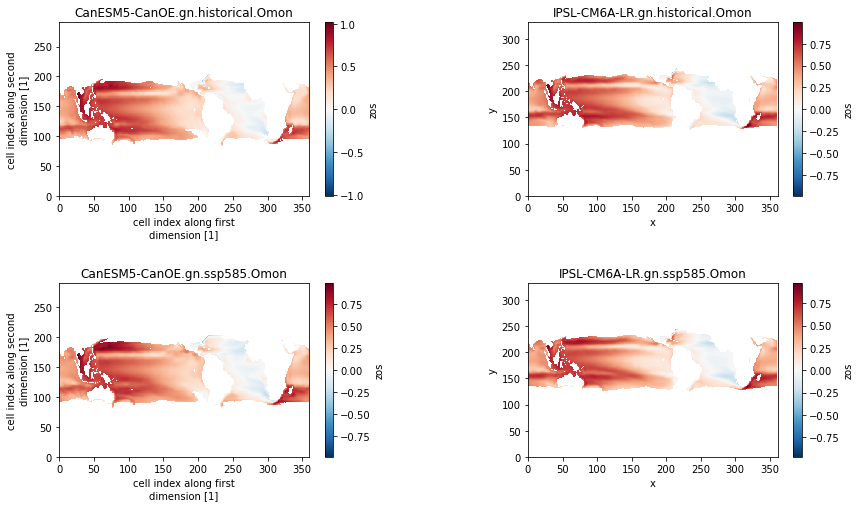

In [50]:
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time=0)
    
    # mask out the SSH where the SST is above 20 deg
    da = ds.zos.where(ds.tos>=20)
    
    # average all members
    if 'member_id' in da.dims:
        da = da.mean('member_id')
    da.plot(ax=ax)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

Thats quite nice. But lets keep going here. Maybe you just want to look at these values in the Indian Ocean?

## Masking ocean basins


In [51]:
import regionmask
from cmip6_preprocessing.regionmask import merged_mask
# load ocean basin data
basins = regionmask.defined_regions.natural_earth.ocean_basins_50

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


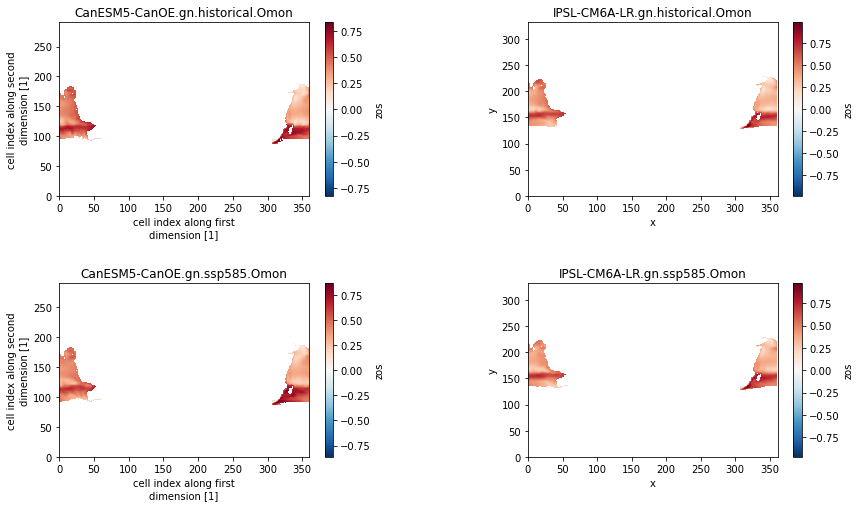

In [52]:
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time=0)

    
    # mask out the SSH where the SST is above 20 deg
    da = ds.zos.where(ds.tos>=20)
    
    # average all members
    if 'member_id' in da.dims:
        da = da.mean('member_id')
        
    # mask out the indian ocean
    mask = merged_mask(basins, da)
    
    da_masked = da.where(mask == 5)
    
    da_masked.plot(ax=ax)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

> Note that the basin is masked out across the periodic boundary (which is slighlty different for each of the models).

Ok lets bring this home. Maybe you want to actually compute a timeseries of these masked sea surface temperatures.

You might be tempted to just do something like this:

[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  9.1s


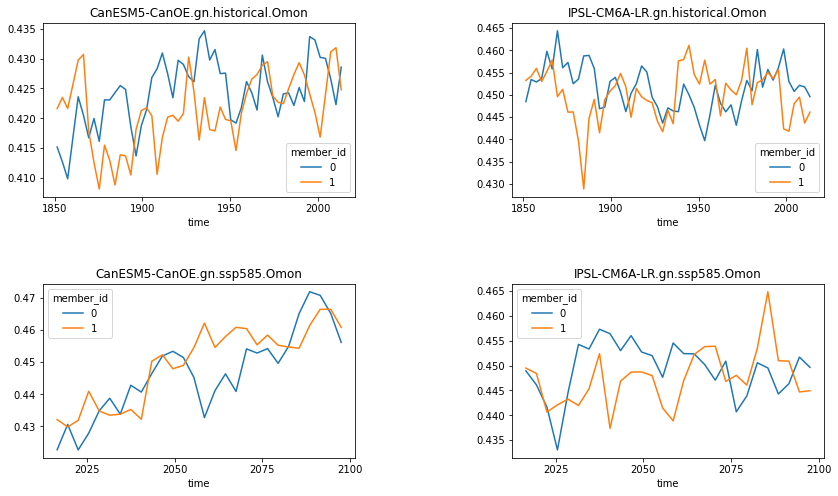

In [53]:
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):    
    # mask out the SSH where the SST is above 20 deg
    da = ds.zos.where(ds.tos>=20)
        
    # mask out the indian ocean
    mask = merged_mask(basins, da)
    
    da_masked = da.where(mask == 5)
    
    da_timeseries = da_masked.mean(['x', 'y'])
    # this is now a heavy computation, using the full dataset!
    with ProgressBar():
        da_timeseries = da_timeseries.load()
    
    da_timeseries = da_timeseries.coarsen(time=36, boundary='trim').mean() # average in 3 year intervals to supress short term variability
    
   
    da_timeseries.plot(ax=ax, hue='member_id')
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

BUT THIS IS NOT CORRECT!

The area of each cell differs! That means we have to actually weigh the values with the surface area, before averaging!

In [67]:
# load the metric data
cat_m = col.search(
    variable_id=['areacello'],# this is the surface area
    source_id=models,
)

# load all datasets into a python dictionary (like before)
ddict_metrics = cat_m.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # ! Important to apply the preprocessing to the metrics as well!
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [69]:
from cmip6_preprocessing.postprocessing import match_metrics
# at the moment the metrics have to be matched before comining datasets
ddict_w_metrics = match_metrics(ddict, ddict_metrics, ['areacello'])

# simply recombine the same way as before


In [72]:
ddict_combined_w_metrics = concat_members(merge_variables(ddict_w_metrics))

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [73]:
ddict_combined_w_metrics['IPSL-CM6A-LR.gn.historical.Omon']

<xarray.Dataset>
Dimensions:        (bnds: 2, member_id: 2, time: 1980, vertex: 4, x: 362, y: 332)
Coordinates:
    lat_verticies  (y, x, vertex) float32 -84.21 -84.21 -84.21 ... 50.11 50.11
    lon_verticies  (y, x, vertex) float32 72.5 72.5 72.5 ... 73.0 72.95 73.0
    lat            (y, x) float32 -84.21 -84.21 -84.21 ... 50.23 50.01 50.01
    lon            (y, x) float32 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object 1850-01-01 00:00:00 ... 2015-01-01 00:...
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360 361
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 324 325 326 327 328 329 330 331
    lon_bounds     (bnds, y, x) float32 72.5 73.5 74.5 75.5 ... 73.03 73.0 72.97
    lat_bounds     (bnds, y, x) float32 -84.21 -84.21 -84.21 ... 50.04 50.04
    areacello      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: bnds, member_id, vertex
Data variables:
    area           (member_id, y, x) float32 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 251, 332, 362), meta=np.ndarray>
    zos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 242, 332, 362), meta=np.ndarray>
Attributes: (12/42)
    CMIP6_CV_version:      cv=6.2.3.5-2-g63b123e
    Conventions:           CF-1.7 CMIP-6.2
    EXPID:                 historical
    NCO:                   "4.6.0"
    activity_id:           CMIP
    branch_method:         standard
    ...                    ...
    sub_experiment_id:     none
    table_id:              Omon
    title:                 IPSL-CM6A-LR model output prepared for CMIP6 / CMI...
    version_id:            v20180803
    intake_esm_varname:    None
    variant_info:          Restart from another point in piControl.. Informat...

> Note the new coordinate `areacello`

Ok now lets do the calculation properly:

In [ ]:
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict_combined_w_metrics.items()):    
    # mask out the SSH where the SST is above 20 deg
    da = ds.zos.where(ds.tos>=20)
        
    # mask out the indian ocean
    mask = merged_mask(basins, da)
    
    da_masked = da.where(mask == 5)
    
    da_timeseries = da_masked.mean(['x', 'y'])
    da_timeseries_weighted = da_masked.weighted(da_masked.areacello.fillna(0)).mean(['x', 'y'])
    
    # this is now a heavy computation, using the full dataset!
    with ProgressBar():
        #Load into memory and average in 3 year intervals to supress short term variability
        da_timeseries = da_timeseries.load().coarsen(time=36, boundary='trim').mean()
        da_timeseries_weighted = da_timeseries_weighted.load().coarsen(time=36, boundary='trim').mean()
    
    
    da_timeseries.plot(ax=ax, hue='member_id', alpha=0.5, color='C0')
    da_timeseries_weighted.plot(ax=ax, hue='member_id', color='C1')
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

[########################################] | 100% Completed | 13.4s
[                                        ] | 0% Completed |  1.6s